In [298]:
from alpha_vantage.timeseries import TimeSeries 
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from progress.bar import Bar

In [299]:
class Market_prediction:
    def __init__(self,Symbol):
        self.__key_av = "6XWB86EWYAUTYR6C"
        self.Symbol = Symbol
    def univariate_data(self,dataset, start_index, end_index, history_size, target_size):
        ''' dataset: conjunto de datos
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la ventana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
        '''  
        data = []
        labels = []

        start_index = start_index + history_size
        if end_index is None:
            end_index = len(dataset) - target_size

        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data.append(np.reshape(dataset[indices], (history_size, 5)))
            labels.append(dataset[i+target_size])
        return np.array(data), np.array(labels)
    def extract_data(self):
        ts = TimeSeries(key=self.__key_av, output_format='pandas')
        self.dataset, meta_data = ts.get_daily_adjusted(symbol= self.Symbol,outputsize="full")
        return self.dataset
    def split_data(self,past_history,future_target,ratio_split):
        self.ratio_split = ratio_split
        self.close_scaler = MinMaxScaler()
        self.scaler = MinMaxScaler()
        params = ["1. open"	,"2. high",	"3. low",	"4. close",	"6. volume"]
        self.close = self.dataset["4. close"]
        self.df= self.scaler.fit_transform(self.dataset[params])
        TRAIN_SPLIT = int(len(self.df)*ratio_split)
        self.X_train, self.Y_train = self.univariate_data(self.df, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
        self.X_test, self.y_test = self.univariate_data(self.df, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)
    def set_model(self,units):
        input_shape = (self.X_train.shape[1], self.X_train.shape[2])
        inputs = Input(input_shape)
        x = Dropout(1-self.ratio_split, name= 'Dropout_01')(inputs)
        x = LSTM(units=units, name='LSTM_layer')(x)
        x = Dropout(1-self.ratio_split, name= 'Dropout_02')(x)
        outputs = Dense(1)(x)

        # model
        self.model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
        self.model.compile(loss='mean_squared_error',optimizer=Adam(0.001))
        return self.model
    def fit_model(self,epochs=10,batch_size=32,validation_split=0.1,verbose=1,shuffle=False): 
        self.epochs= epochs
        self.train_history = self.model.fit(
        self.X_train, 
        self.Y_train,
        epochs = self.epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        verbose=verbose,
        shuffle=shuffle)
    def plot_loss(self):
        plt.plot(self.train_history.history['loss'][:], label='train')
        plt.plot(self.train_history.history['val_loss'][:], label='test')
        plt.legend()
        plt.show()
    def validate(self):
        prediction1 = self.model.predict(self.X_test)
        self.y_train_p1 = self.Y_train #np.squeeze(y_train, axis=-1)
        self.y_test_p1 = self.y_test#np.squeeze(y_test, axis=-1)
        self.y_pred_p1 = np.squeeze(prediction1, axis=-1)
        k=0
        for i,j in zip(self.y_test_p1, self.y_pred_p1):
            print (i,j, i-j)
            k+=1
            if k==10:
                break
    def predict(self,X):
        self.prediction = self.model.predict(X)
    def plot_prediction(self):
        plt.plot(np.arange(0, len(self.y_train_p1)), self.y_train_p1[:, 3], 'g', label="historia")
        plt.plot(np.arange(len(self.y_train_p1), len(self.y_train_p1) + len(self.y_test_p1)), self.y_test_p1[:, 3], marker='.', label="verdadero")
        plt.plot(np.arange(len(self.y_train_p1), len(self.y_train_p1) + len(self.y_test_p1)), self.y_pred_p1, 'r', label="predicción")
        #plt.ylabel('Valor')
        plt.xlabel('Time Step')
        plt.title("{}: Historia del precio la acción al cierre. Escala (0,1)".format(self.Symbol), size = 20)
        plt.legend()
        plt.show()
    def trust(self):
        lower_bound = np.percentile(self.y_train_p1[:,3], 2.5, axis=0)
        upper_bound = np.percentile(self.y_train_p1[:,3], 97.5, axis=0)
        return lower_bound , upper_bound
    def original_scale(self):
        self.y_pred_or1 = self.y_pred_p1  * ( self.close.max() - self.close.min()) + self.close.min()
        self.y_test_or1 = self.y_test_p1[:,3] * (self.close.max() - self.close.min()) + self.close.min()
        self.rmsLSTM = np.sqrt(np.mean(np.power(self.y_pred_or1-self.y_test_or1,2)))
    def plot_original_scale(self):
        plt.plot(np.arange(0, len(self.y_test_or1)), self.y_test_or1, marker='.', label="verdadero")
        plt.plot(np.arange(0, len(self.y_test_or1)), self.y_pred_or1, marker='+', label="predicho")
        plt.xlabel('Time Step')
        plt.annotate("rms = "+str(round(self.rmsLSTM,2)) , xy=(100, 140), size = 15)
        plt.annotate("epochs={}".format(self.epochs) , xy=(100, 143), size = 15)
        plt.title("{}: Intervalo de predicción a un día. Escala original".format(self.Symbol), size = 20)
        plt.legend()
        plt.show();

In [300]:
IBM.close.max()

215.8

IBM


Epoch 1/10
116/116 [==============================] - 2s 6ms/step - loss: 0.0762 - val_loss: 0.0061
Epoch 2/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0546 - val_loss: 0.0067
Epoch 3/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0079
Epoch 4/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0075
Epoch 5/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0070
Epoch 6/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0070
Epoch 7/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0070
Epoch 8/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0066
Epoch 9/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0065
Epoch 10/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0062

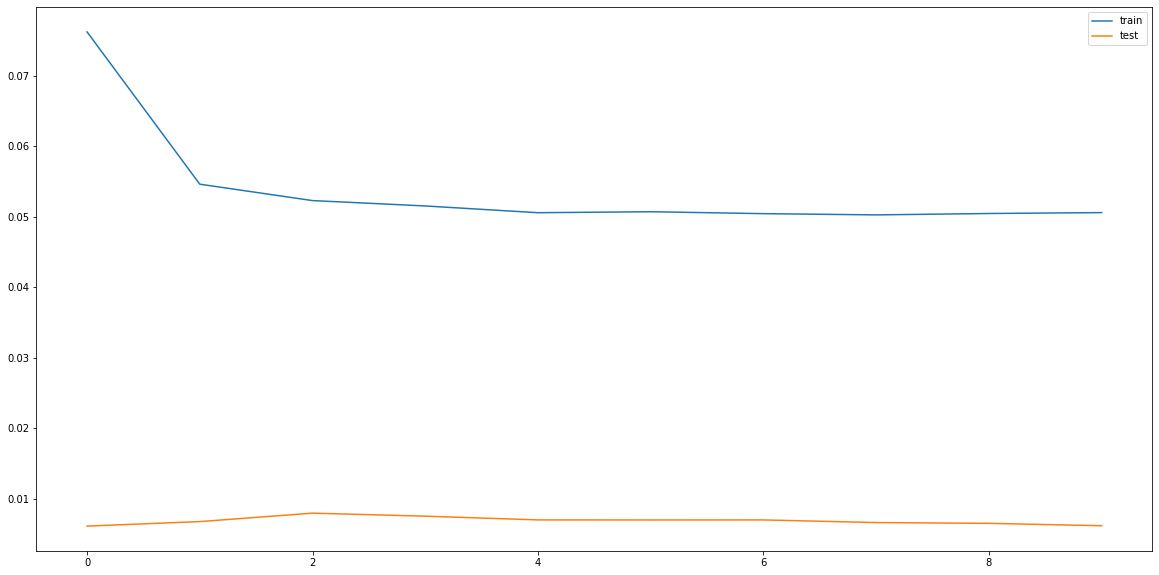

55/55 [==============================] - 0s 1ms/step
[0.19554532 0.19409548 0.1980161  0.19685186 0.20578736] 0.2500235 [-0.05447819 -0.05592804 -0.05200742 -0.05317165 -0.04423615]
[0.18540409 0.18536432 0.18984341 0.19293225 0.18519706] 0.23522678 [-0.04982269 -0.04986246 -0.04538337 -0.04229453 -0.05002972]
[0.18384869 0.17713568 0.18772225 0.18434642 0.10895809] 0.2383583 [-0.05450961 -0.06122263 -0.05063605 -0.05401188 -0.12940021]
[0.18353761 0.17579711 0.18578826 0.1811734  0.12234118] 0.24089989 [-0.05736228 -0.06510278 -0.05511163 -0.05972649 -0.11855871]
[0.1808001  0.1754397  0.18435336 0.1811734  0.11020643] 0.24095063 [-0.06015053 -0.06551093 -0.05659727 -0.05977723 -0.1307442 ]
[0.17725378 0.17198492 0.18085969 0.17999129 0.10477664] 0.24225187 [-0.06499809 -0.07026695 -0.06139218 -0.06226058 -0.13747523]
[0.17594724 0.1701005  0.17774035 0.1746407  0.12551811] 0.24149638 [-0.06554914 -0.07139588 -0.06375604 -0.06685568 -0.11597828]
[0.17520065 0.1665201  0.17836421 0.173

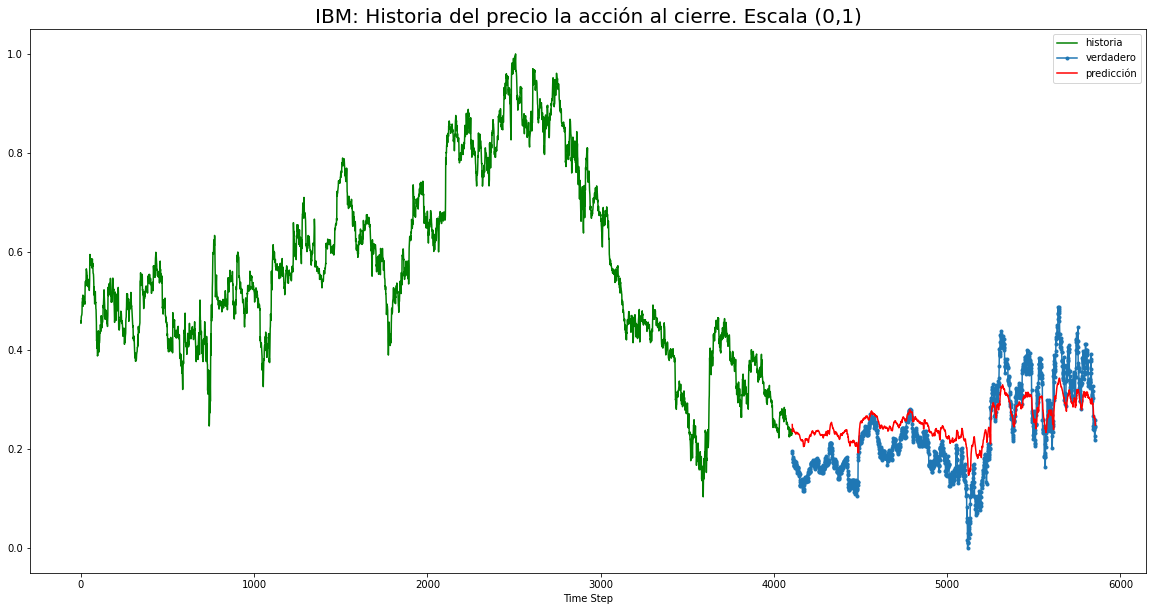

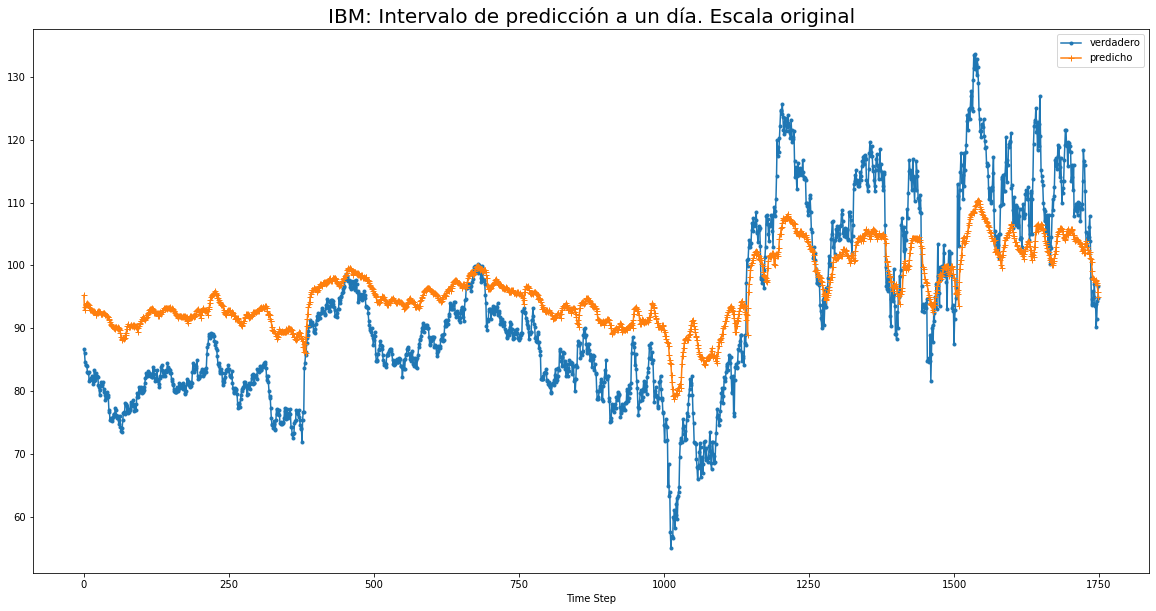

In [309]:
IBM = Market_prediction("IBM")
df_IBM=IBM.extract_data()
IBM.split_data(15,2,0.70)
IBM.set_model(25)
IBM.fit_model()
IBM.plot_loss()
IBM.validate()
IBM.plot_prediction()
IBM.trust()
IBM.original_scale()
IBM.plot_original_scale()


PFIZER (PFE)

Epoch 1/10
132/132 [==============================] - 2s 7ms/step - loss: 0.0571 - val_loss: 0.0109
Epoch 2/10
132/132 [==============================] - 1s 5ms/step - loss: 0.0288 - val_loss: 0.0098
Epoch 3/10
132/132 [==============================] - 1s 5ms/step - loss: 0.0267 - val_loss: 0.0096
Epoch 4/10
132/132 [==============================] - 1s 5ms/step - loss: 0.0259 - val_loss: 0.0096
Epoch 5/10
132/132 [==============================] - 1s 5ms/step - loss: 0.0254 - val_loss: 0.0095
Epoch 6/10
132/132 [==============================] - 1s 5ms/step - loss: 0.0250 - val_loss: 0.0096
Epoch 7/10
132/132 [==============================] - 1s 5ms/step - loss: 0.0250 - val_loss: 0.0096
Epoch 8/10
132/132 [==============================] - 1s 5ms/step - loss: 0.0249 - val_loss: 0.0096
Epoch 9/10
132/132 [==============================] - 1s 5ms/step - loss: 0.0247 - val_loss: 0.0096
Epoch 10/10
132/132 [==============================] - 1s 5ms/step - loss: 0.0248 - val_loss: 0.0096

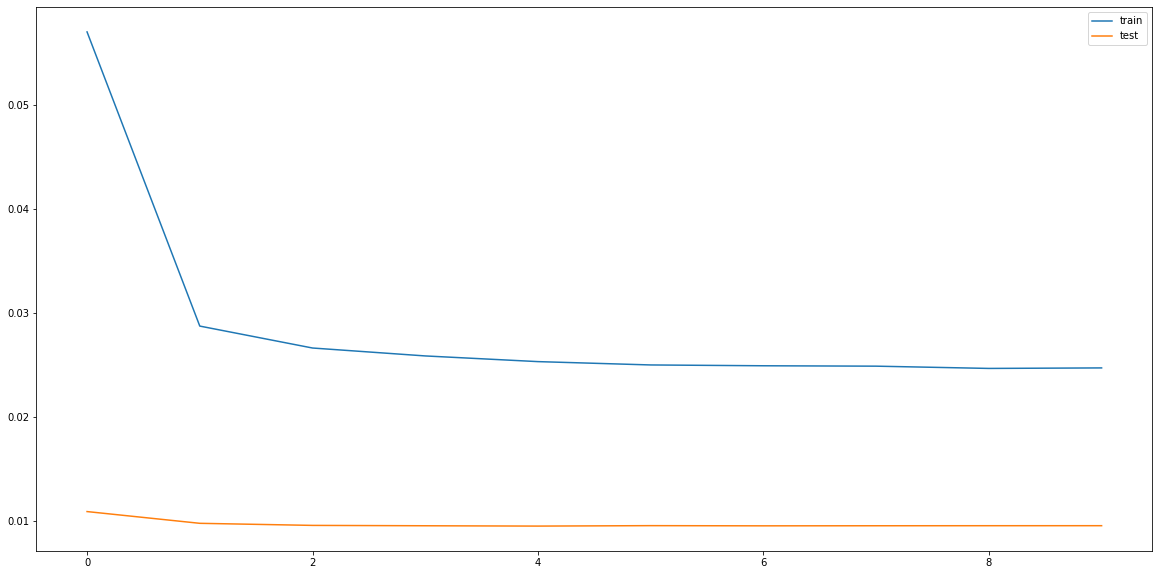

36/36 [==============================] - 0s 2ms/step
[0.49128205 0.47779572 0.48703588 0.47408752 0.02788337] 0.35157812 [ 0.13970393  0.1262176   0.13545777  0.1225094  -0.32369475]
[0.48512821 0.47496972 0.49014727 0.48175035 0.02587864] 0.3497674 [ 0.13536082  0.12520233  0.14037989  0.13198297 -0.32388875]
[0.47692308 0.47920872 0.48496163 0.48074209 0.028733  ] 0.34763283 [ 0.12929025  0.13157589  0.1373288   0.13310926 -0.31889983]
[0.47938462 0.48102543 0.48911014 0.48275862 0.02825733] 0.3456561 [ 0.13372852  0.13536934  0.14345405  0.13710252 -0.31739877]
[0.48       0.47335486 0.48599876 0.47872555 0.03216158] 0.34505928 [ 0.13494072  0.12829559  0.14093948  0.13366627 -0.3128977 ]
[0.48923077 0.47597901 0.4839245  0.48497681 0.04588815] 0.3449989 [ 0.14423187  0.13098011  0.1389256   0.13997791 -0.29911075]
[0.49128205 0.48122729 0.49429579 0.48900988 0.04073583] 0.34636092 [ 0.14492113  0.13486637  0.14793487  0.14264896 -0.30562509]
[0.49948718 0.48584982 0.4976146  0.4908

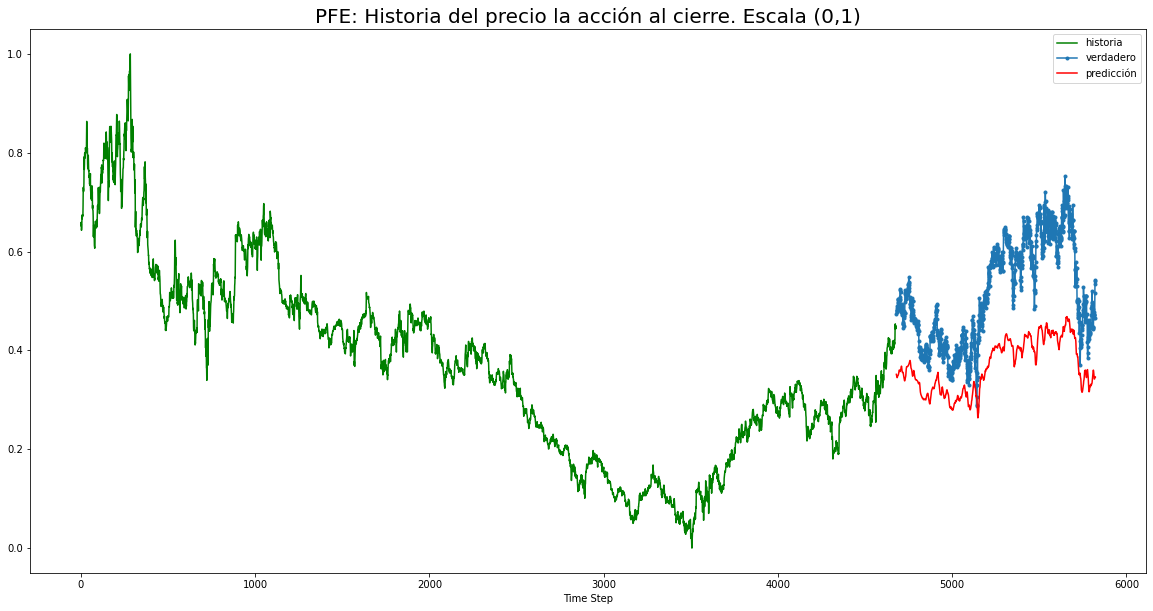

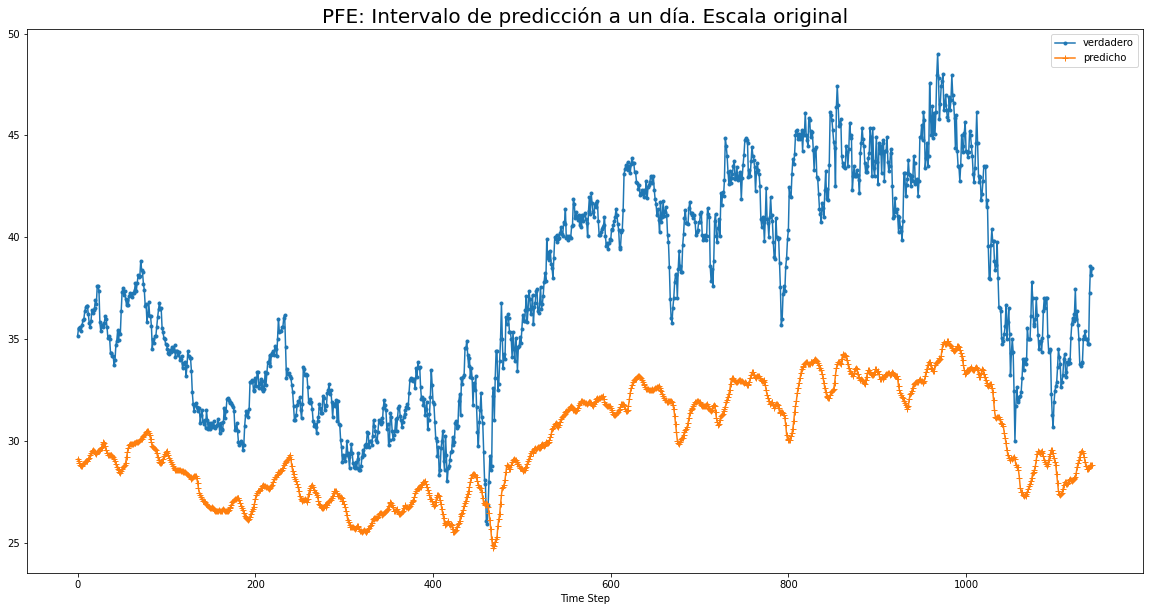

In [310]:
PFE = Market_prediction("PFE")
df_PFE=PFE.extract_data()
PFE.split_data(30,5,0.8)
PFE.set_model(30)
PFE.fit_model()
PFE.plot_loss()
PFE.validate()
PFE.plot_prediction()
PFE.trust()
PFE.original_scale()
PFE.plot_original_scale()

 Nasdaq-100 Index Fund (VCNIX)

Epoch 1/10
127/127 [==============================] - 2s 10ms/step - loss: 0.0350 - val_loss: 0.0012
Epoch 2/10
127/127 [==============================] - 1s 8ms/step - loss: 0.0304 - val_loss: 0.0012
Epoch 3/10
127/127 [==============================] - 1s 8ms/step - loss: 0.0304 - val_loss: 0.0011
Epoch 4/10
127/127 [==============================] - 1s 8ms/step - loss: 0.0315 - val_loss: 0.0011
Epoch 5/10
127/127 [==============================] - 1s 8ms/step - loss: 0.0323 - val_loss: 0.0011
Epoch 6/10
127/127 [==============================] - 1s 8ms/step - loss: 0.0311 - val_loss: 0.0011
Epoch 7/10
127/127 [==============================] - 1s 8ms/step - loss: 0.0307 - val_loss: 0.0011
Epoch 8/10
127/127 [==============================] - 1s 8ms/step - loss: 0.0308 - val_loss: 0.0011
Epoch 9/10
127/127 [==============================] - 1s 8ms/step - loss: 0.0306 - val_loss: 0.0011
Epoch 10/10
127/127 [==============================] - 1s 8ms/step - loss: 0.0299 - val_loss: 0.001

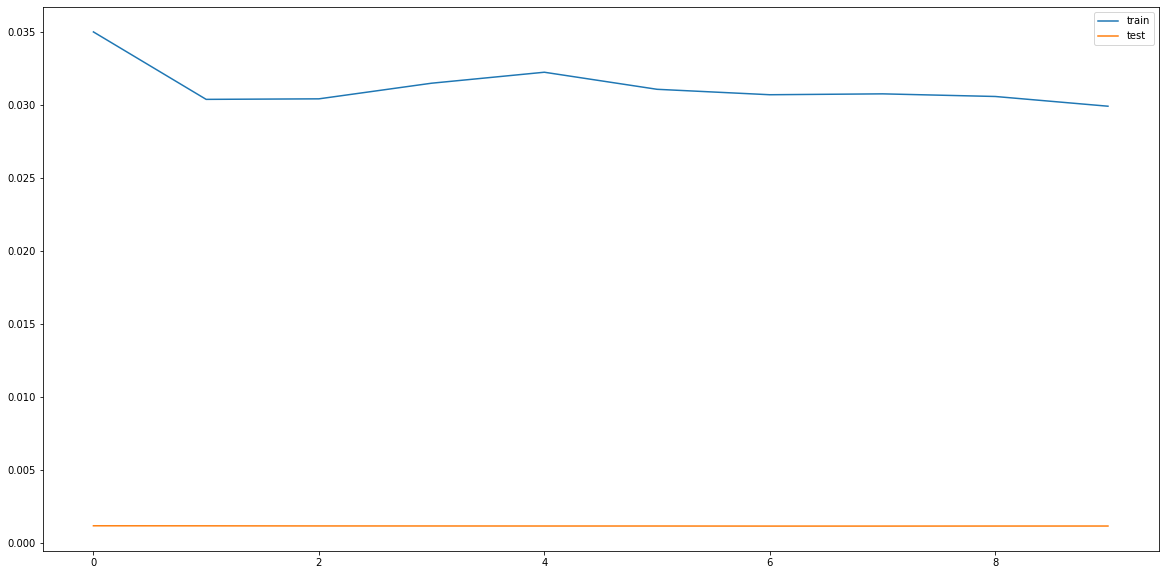

35/35 [==============================] - 0s 3ms/step
[0.07454342 0.07454342 0.07454342 0.07454342 0.        ] 0.06215562 [ 0.0123878   0.0123878   0.0123878   0.0123878  -0.06215562]
[0.0719344 0.0719344 0.0719344 0.0719344 0.       ] 0.062268637 [ 0.00966576  0.00966576  0.00966576  0.00966576 -0.06226864]
[0.07379799 0.07379799 0.07379799 0.07379799 0.        ] 0.062434454 [ 0.01136353  0.01136353  0.01136353  0.01136353 -0.06243445]
[0.07342527 0.07342527 0.07342527 0.07342527 0.        ] 0.062043972 [ 0.0113813   0.0113813   0.0113813   0.0113813  -0.06204397]
[0.07305255 0.07305255 0.07305255 0.07305255 0.        ] 0.062089793 [ 0.01096276  0.01096276  0.01096276  0.01096276 -0.06208979]
[0.07118897 0.07118897 0.07118897 0.07118897 0.        ] 0.062065672 [ 0.0091233   0.0091233   0.0091233   0.0091233  -0.06206567]
[0.0719344 0.0719344 0.0719344 0.0719344 0.       ] 0.06197446 [ 0.00995994  0.00995994  0.00995994  0.00995994 -0.06197446]
[0.0719344 0.0719344 0.0719344 0.0719344 0

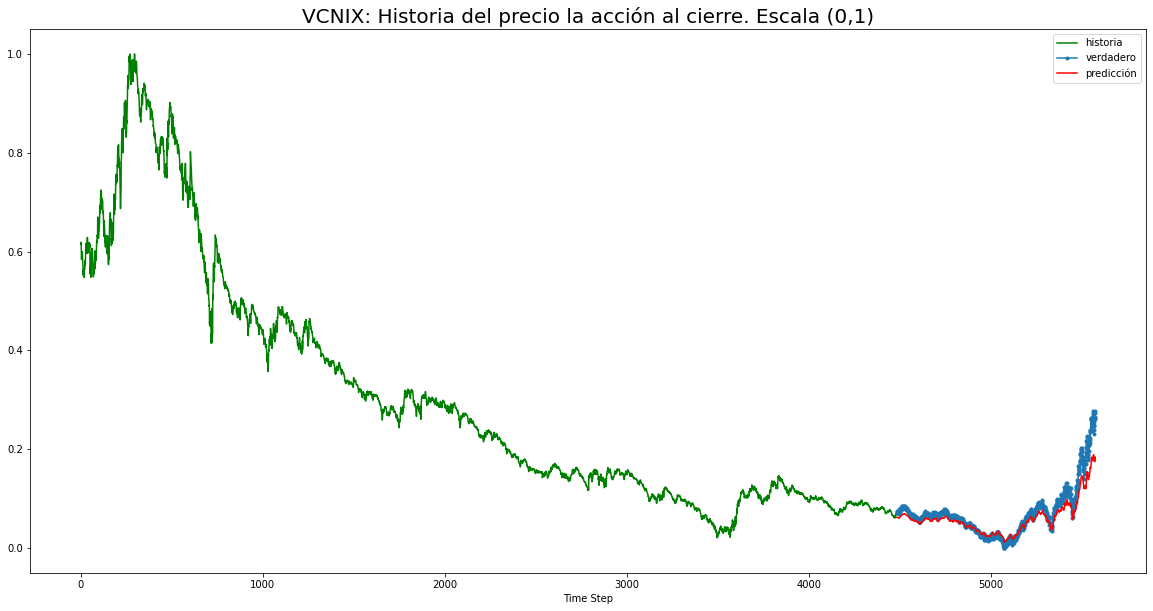

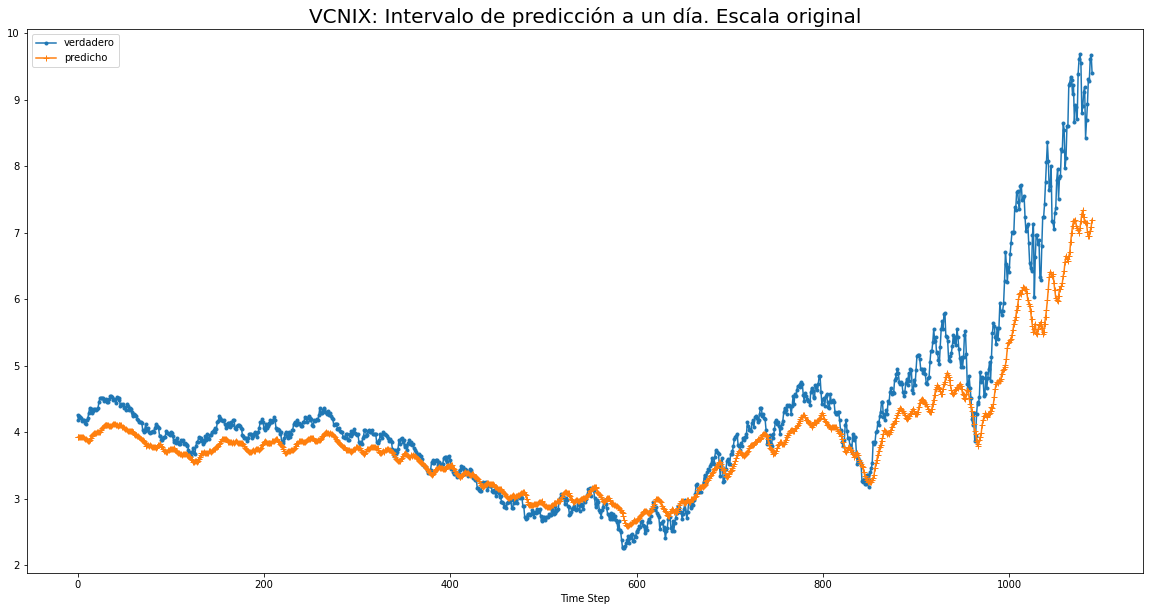

In [311]:
VCNIX = Market_prediction("VCNIX")
df_VCNIX=VCNIX.extract_data()
VCNIX.split_data(40,1,0.8)
VCNIX.set_model(50)
VCNIX.fit_model()
VCNIX.plot_loss()
VCNIX.validate()
VCNIX.plot_prediction()
VCNIX.trust()
VCNIX.original_scale()
VCNIX.plot_original_scale()

META (META)

Epoch 1/10
59/59 [==============================] - 2s 20ms/step - loss: 0.0462 - val_loss: 0.0027
Epoch 2/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0441 - val_loss: 0.0029
Epoch 3/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0448 - val_loss: 0.0035
Epoch 4/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0428 - val_loss: 0.0033
Epoch 5/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0421 - val_loss: 0.0032
Epoch 6/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0420 - val_loss: 0.0031
Epoch 7/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0416 - val_loss: 0.0031
Epoch 8/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0418 - val_loss: 0.0031
Epoch 9/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0417 - val_loss: 0.0031
Epoch 10/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0417 - val_loss: 0.0030


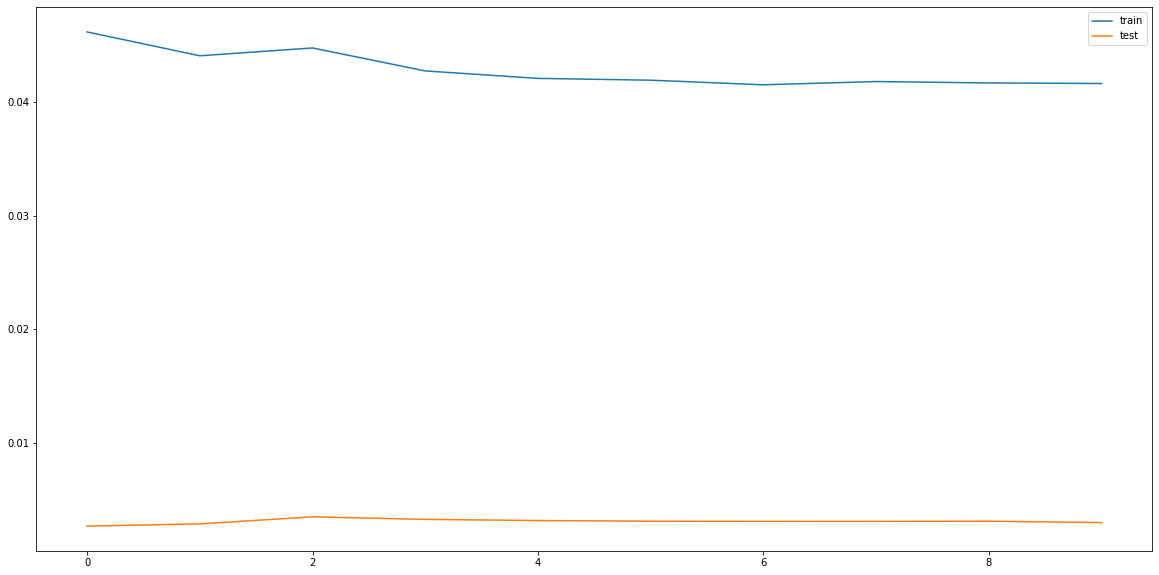

15/15 [==============================] - 0s 6ms/step
[0.14634213 0.14500355 0.14006533 0.14021364 0.09015543] 0.14425547 [ 0.00208666  0.00074808 -0.00419015 -0.00404184 -0.05410004]
[0.14240924 0.14500355 0.1424182  0.14583826 0.07121727] 0.1451492 [-0.00273996 -0.00014565 -0.002731    0.00068906 -0.07393193]
[0.14966997 0.14839097 0.14507557 0.14369833 0.09423761] 0.14776438 [ 0.00190558  0.00062659 -0.00268882 -0.00406605 -0.05352678]
[0.14491199 0.14718899 0.14659802 0.14899397 0.09505376] 0.14843372 [-0.00352172 -0.00124473 -0.0018357   0.00056025 -0.05337996]
[0.14576458 0.14453915 0.14371921 0.14287517 0.05815759] 0.15128691 [-0.00552234 -0.00674777 -0.00756771 -0.00841174 -0.09312932]
[0.1479648  0.14647872 0.14587831 0.14572878 0.07066413] 0.15334338 [-0.00537858 -0.00686466 -0.00746506 -0.0076146  -0.08267925]
[0.14194169 0.14669726 0.14413442 0.14773179 0.12094252] 0.15178682 [-0.00984512 -0.00508956 -0.0076524  -0.00405503 -0.0308443 ]
[0.13910891 0.13831066 0.13859824 0.14

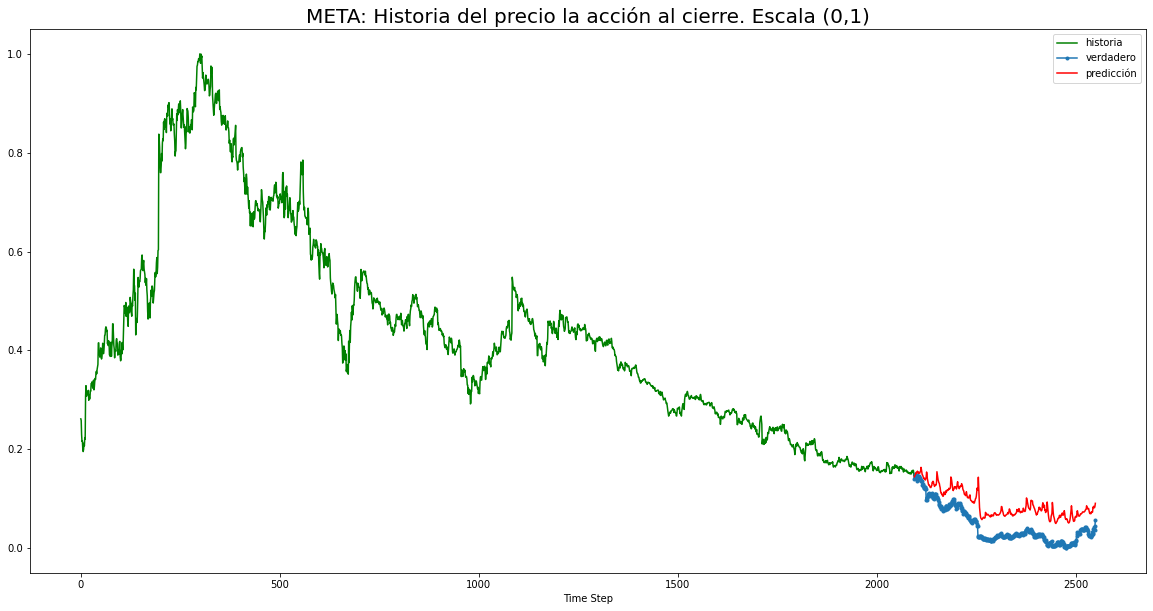

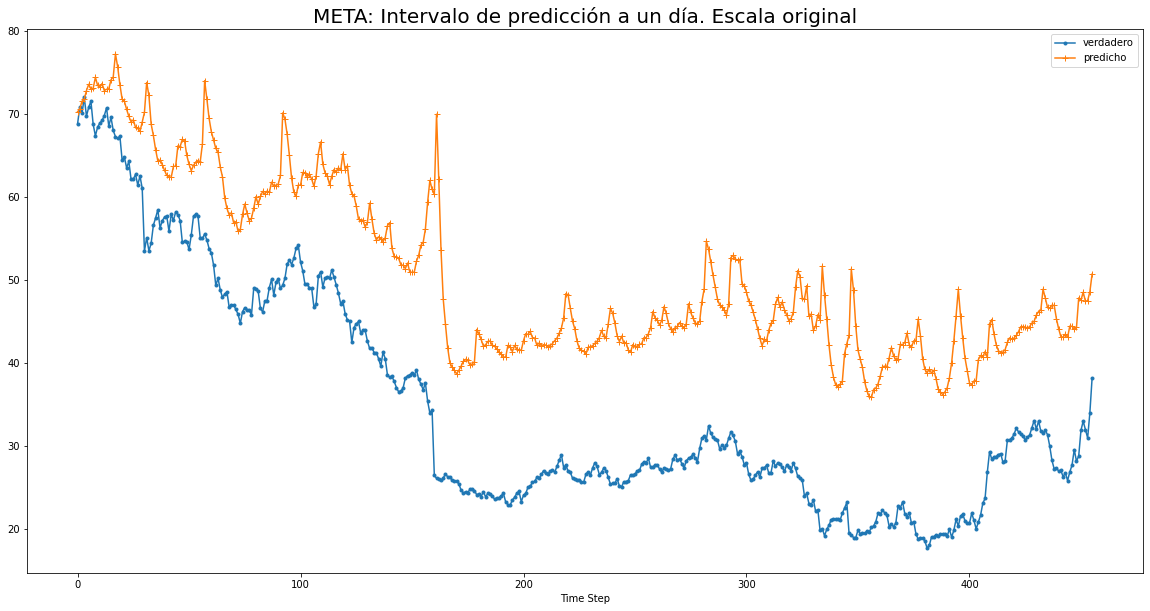

In [304]:
META = Market_prediction("META")
df_META=META.extract_data()
META.split_data(90,1,0.8)
META.set_model(50)
META.fit_model()
META.plot_loss()
META.validate()
META.plot_prediction()
META.trust()
META.original_scale()
META.plot_original_scale()

Ecopetrol (EC)

Epoch 1/10
82/82 [==============================] - 2s 6ms/step - loss: 0.0179 - val_loss: 0.0861
Epoch 2/10
82/82 [==============================] - 0s 4ms/step - loss: 0.0161 - val_loss: 0.0877
Epoch 3/10
82/82 [==============================] - 0s 3ms/step - loss: 0.0155 - val_loss: 0.0870
Epoch 4/10
82/82 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0864
Epoch 5/10
82/82 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0854
Epoch 6/10
82/82 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.0862
Epoch 7/10
82/82 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.0863
Epoch 8/10
82/82 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.0876
Epoch 9/10
82/82 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0871
Epoch 10/10
82/82 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0884


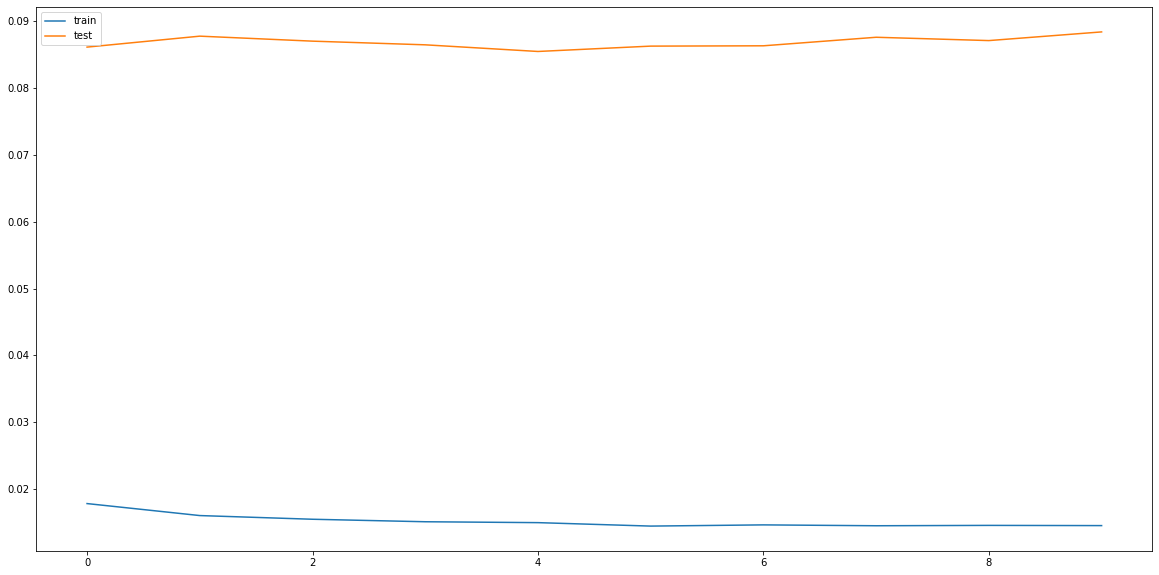

23/23 [==============================] - 0s 1ms/step
[0.59433198 0.60877924 0.60601084 0.6029317  0.0939003 ] 0.55348885 [ 0.04084313  0.05529039  0.05252199  0.04944285 -0.45958855]
[0.59838057 0.59227812 0.6042043  0.59536082 0.02936803] 0.5553864 [ 0.04299414  0.03689169  0.04881788  0.0399744  -0.52601839]
[0.59821862 0.59115668 0.60175398 0.59342784 0.02560995] 0.55628973 [ 0.04192889  0.03486695  0.04546425  0.0371381  -0.53067978]
[0.59773279 0.58955463 0.60305469 0.58875644 0.01880758] 0.5571483 [ 0.04058452  0.03240635  0.04590641  0.03160817 -0.5383407 ]
[0.58979757 0.58891381 0.59550008 0.59165593 0.04377255] 0.55726063 [ 0.03253694  0.03165318  0.03823945  0.0343953  -0.51348808]
[0.5734413  0.57705864 0.58104779 0.5808634  0.04187202] 0.5569832 [ 0.01645812  0.02007546  0.02406462  0.02388023 -0.51511116]
[0.58234818 0.58138417 0.58383971 0.57135954 0.03181035] 0.55586183 [ 0.02648635  0.02552234  0.02797788  0.01549771 -0.52405148]
[0.58445344 0.58362704 0.58876663 0.5750

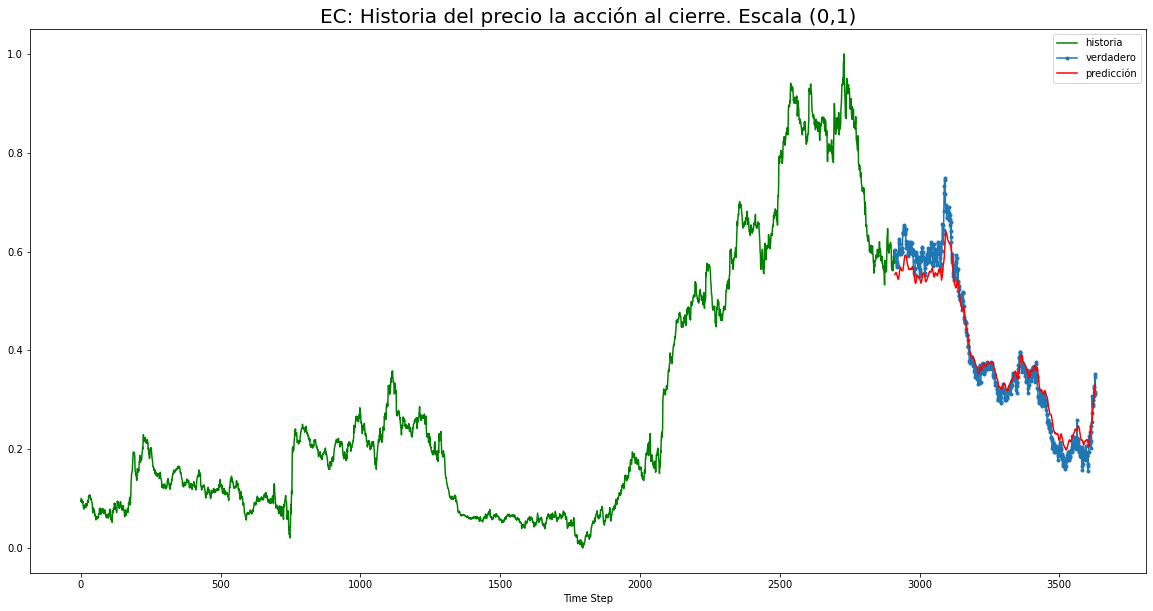

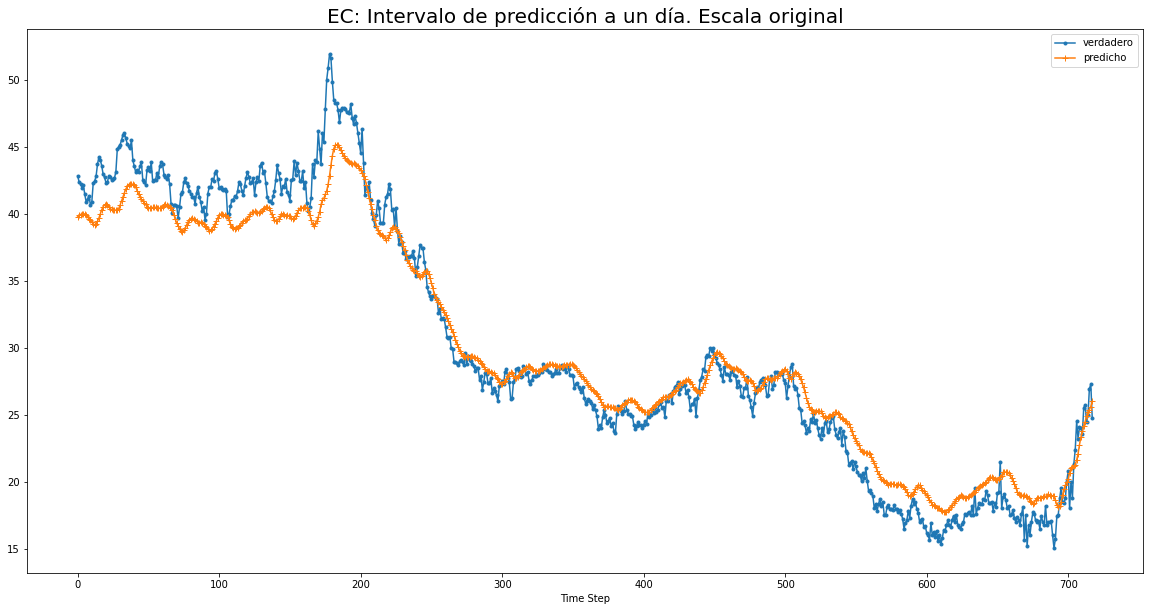

In [316]:
EC = Market_prediction("EC")
df_EC=EC.extract_data()
EC.split_data(12,1,0.8)
EC.set_model(50)
EC.fit_model()
EC.plot_loss()
EC.validate()
EC.plot_prediction()
EC.trust()
EC.original_scale()
EC.plot_original_scale()